In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams['figure.dpi'] = 450

In [2]:
# data_dir = 'D:\\RST\\notebook\\networks\\'
# root_dir = 'D:\\RST\\notebook\\'

In [3]:
root_dir = '/Volumes/Data2/RST/notebook/'
data_dir = '/Volumes/Data2/RST/notebook/networks/'

In [4]:
tts = pd.read_csv(root_dir + 'TTS OD/TTS_TYPE.csv')
tts = tts.rename(columns = {'origin':'o_node', 'destination':'d_node'})

In [5]:
period_order = pd.DataFrame.from_records([['EM', 1], ['AM', 2], ['MD', 3], ['PM', 4], ['EV', 5]], 
                          columns = ['period', 'period_order'])

In [6]:
df_list = []
for period in ['EM', 'AM', 'MD', 'PM', 'EV']:
    
    for weight_type in ['raw', 'lico', 'c0', 'imm', 'rac', 'bl', 'lep']:

        bc_avg = pd.read_csv(data_dir + period + '/' + 'BC-' + period + '_edge-avg.csv' )

        bc_avg['o_node'] = bc_avg['o_node'] - 1000
        bc_avg['d_node'] = bc_avg['d_node'] - 1000

        period_tts = tts[tts['type'] == weight_type + '_' + period.lower()]

        stop_times_od = pd.read_csv(root_dir + 'networks/' + period + '-TE-16-8.csv')
        N = len((stop_times_od['INT_ID_o'].append(stop_times_od['INT_ID_d'])).drop_duplicates())

        bc_all = bc_avg.merge(period_tts)
        bc_od = bc_all.copy()
        bc_all['weighted'] = (bc_all['bc_single'] * bc_all['total'])
        bc_all = bc_all.groupby(['INT_ID_o','INT_ID_d', 'route']).agg({'weighted':'sum'}).reset_index()
        bc_all['weighted'] = bc_all['weighted']/((N - 1) * (N - 2) * period_tts['total'].sum())
        bc_all['type'] = weight_type + '_' + period.lower()
        
        df_list.append(bc_all)


In [7]:
bc_type = pd.concat(df_list)

In [8]:
bc_type[bc_type['route']==34].sort_values(by = 'weighted').tail(10)

,INT_ID_o,INT_ID_d,route,weighted,type
2126,13453963,13453958,34.0,1.307485e-09,bl_em
2131,13453978,13454107,34.0,1.307485e-09,bl_em
2151,13454074,13453963,34.0,1.307485e-09,bl_em
2026,13453325,13453473,34.0,1.317584e-09,bl_em
2001,13453221,13453325,34.0,1.317584e-09,bl_em
2062,13453588,14074105,34.0,1.317584e-09,bl_em
2046,13453473,13453588,34.0,1.317584e-09,bl_em
1799,13456902,13456978,34.0,1.364632e-09,c0_em
1809,13456978,13457078,34.0,1.395646e-09,c0_em
1816,13457078,111,34.0,1.457675e-09,c0_em


In [9]:
bc_type.to_csv('bc_weighted_edge.csv', index = False)

In [10]:
bc_type[bc_type['type'] =='lico_am']['weighted'].quantile(0.95)

4.960339069852555e-10

In [11]:
9.320623e-10 > 5.143386945941273e-10

True

In [12]:
df_list = []

for period in ['AM', 'MD', 'PM', 'EV']:
    
    for weight_type in ['raw', 'lico', 'c0', 'imm', 'rac', 'bl', 'lep']:
        
        type_str = weight_type + '_' + period.lower()
        data = bc_type[bc_type['type'] == type_str].copy()
        
        cutoff = data['weighted'].quantile(0.95)
        
        data = data[data['weighted'] >= cutoff]
        
        df_list.append(data)

In [13]:
bc_cutoff = pd.concat(df_list)
bc_cutoff

,INT_ID_o,INT_ID_d,route,weighted,type
0,100,101,1.0,1.546427e-09,raw_am
1,100,151,1.0,1.551585e-09,raw_am
10,101,100,1.0,3.581136e-09,raw_am
13,101,102,1.0,9.525994e-10,raw_am
25,102,101,1.0,5.600524e-09,raw_am
...,...,...,...,...,...
7636,14659127,13462686,89.0,9.941311e-10,lep_ev
7642,14673438,13445306,60.0,8.582015e-10,lep_ev
7666,20056886,13468374,504.0,7.423086e-10,lep_ev
7729,30104484,13444841,42.0,1.498344e-09,lep_ev


In [14]:
bc_cutoff[bc_cutoff['route']==32].sort_values(by = 'weighted').tail(10)

,INT_ID_o,INT_ID_d,route,weighted,type
6468,13460119,13459957,32.0,1.064314e-09,bl_am
6417,13459957,13459821,32.0,1.064941e-09,bl_am
6226,13459303,13459208,32.0,1.089800e-09,lep_am
6189,13459208,13459036,32.0,1.103842e-09,lep_am
6375,13459821,13459781,32.0,1.130316e-09,bl_am
6262,13459413,13459303,32.0,1.273238e-09,bl_am
6323,13459608,13459413,32.0,1.281734e-09,bl_am
6350,13459781,13459608,32.0,1.328665e-09,bl_am
6226,13459303,13459208,32.0,1.336036e-09,bl_am
6189,13459208,13459036,32.0,1.353191e-09,bl_am


In [15]:
inner_to_stn = [100,101,102,103,104,105,106,107,108,109,110,111,112,
                151,152,153,154,155,156,157,158,159,
               203,204,205,206,207,208,209,210,211,212,213,214,215,
                216,217,218,219,220,221,222,223,224]

streetcar_routes = [501,502,503,504,505,506,509,510,511,512,514]

frequent_routes = [7,22,24,25,29,32,34,35,36,39,43,44,47,
                   52,53,54,60,63,69,70,72,76,84,85,86,87,89,94,100,102,
                  116,129,165]

outer_to_stn = pd.read_csv(root_dir + 'GIS/stations.csv')
outer_to_stn = list(outer_to_stn[~outer_to_stn['INT_ID'].isin(inner_to_stn)]['INT_ID'].drop_duplicates())

In [16]:
stop_times = pd.read_csv(root_dir + 'GTFS/TTC_2016-10-03/stop_times_reduced.csv')
stop_trips = stop_times.merge(pd.read_csv(root_dir + 'GTFS/TTC_2016-10-03/trips_weekday.csv'))

In [17]:
od_df_list = []
for period in ['AM', 'MD', 'PM', 'EV']:
    od_df_list.append(pd.read_csv(data_dir + period + '-TE-16-8.csv'))
    
stop_times_od = pd.concat(od_df_list)

In [18]:
edge_route = stop_times_od[['INT_ID_o', 'INT_ID_d', 'route_short_name']].drop_duplicates()
edge_route = edge_route.rename(columns = {'route_short_name':'route'})

In [19]:
inner_edges = edge_route[(edge_route['INT_ID_o'].isin(inner_to_stn)) & 
                         (edge_route['INT_ID_d'].isin(inner_to_stn)) & (edge_route['route'].isin([1,2]))][['INT_ID_o', 'INT_ID_d','route']].drop_duplicates()
inner_edges['edge_type'] = 'Inner Subway Station'

In [20]:
outer_edges = edge_route[((edge_route['INT_ID_o'].isin(outer_to_stn)) | 
                         (edge_route['INT_ID_d'].isin(outer_to_stn))) &  (edge_route['route'].isin([1,2,3,4]))][['INT_ID_o', 'INT_ID_d', 'route']].drop_duplicates()
outer_edges = outer_edges[(outer_edges['INT_ID_o'] < 1000) & 
                         (outer_edges['INT_ID_d']< 1000)]
outer_edges['edge_type'] = 'Outer Subway Station'

In [21]:
restricted_edges = outer_edges.append(inner_edges)

In [22]:
streetcar_edges = edge_route[edge_route['route'].isin(streetcar_routes)][['INT_ID_o', 'INT_ID_d', 'route']].drop_duplicates()

In [23]:
streetcar_edges['edge_type'] = 'Streetcar Route'
restricted_edges = restricted_edges.append(streetcar_edges)

In [24]:
frequent_edges = edge_route[edge_route['route'].isin(frequent_routes)]
frequent_edges = frequent_edges[~frequent_edges['route'].isin(streetcar_routes)]
frequent_edges = frequent_edges[~frequent_edges['route'].isin([1,2,3,4])][['INT_ID_o', 'INT_ID_d', 'route']].drop_duplicates()

In [25]:
frequent_edges['edge_type'] = 'Frequent Bus Route'

restricted_edges = restricted_edges.append(frequent_edges)

In [26]:
local_edges = edge_route[~((edge_route['INT_ID_o'].isin(restricted_edges['INT_ID_o'])) & 
                         (edge_route['INT_ID_d'].isin(restricted_edges['INT_ID_d'])) &
           (edge_route['route'].isin(restricted_edges['route'])))][['INT_ID_o', 'INT_ID_d', 'route']].drop_duplicates()

local_edges['edge_type'] = 'Bus Route'

In [27]:
edge_directory = inner_edges.append(outer_edges).append(streetcar_edges).append(frequent_edges).append(local_edges)
edge_directory = edge_directory.drop_duplicates(subset = ['INT_ID_o', 'INT_ID_d', 'route'], keep = 'first')


In [28]:
edge_directory[edge_directory['edge_type'] == 'Frequent Bus Route']

,INT_ID_o,INT_ID_d,route,edge_type
24447,13459249.0,13459366.0,100,Frequent Bus Route
24448,13459366.0,13459492.0,100,Frequent Bus Route
24449,13459492.0,13459803.0,100,Frequent Bus Route
24450,13459803.0,13460112.0,100,Frequent Bus Route
24451,13460112.0,13460586.0,100,Frequent Bus Route
...,...,...,...,...
361110,13454288.0,13454774.0,70,Frequent Bus Route
361111,13454774.0,13454909.0,70,Frequent Bus Route
387997,13452251.0,13453059.0,84,Frequent Bus Route
31295,228.0,13452869.0,116,Frequent Bus Route


In [29]:
bc_cutoff[bc_cutoff['route']==34]

,INT_ID_o,INT_ID_d,route,weighted,type
4280,13453958,13454202,34.0,5.308242e-10,raw_am
4282,13453963,13453958,34.0,5.134615e-10,raw_am
4329,13454074,13453963,34.0,4.344083e-10,raw_am
4345,13454107,13454074,34.0,4.344055e-10,raw_am
4390,13454202,13454313,34.0,4.122806e-10,raw_am
...,...,...,...,...,...
5025,13455720,13455296,34.0,5.312653e-10,bl_pm
5075,13455899,13455720,34.0,5.071099e-10,bl_pm
5127,13455990,13455899,34.0,4.818801e-10,bl_pm
5178,13456160,13456085,34.0,4.710057e-10,bl_pm


In [30]:
bc_cutoff = bc_cutoff.merge(edge_directory)

In [31]:
bc_cutoff['count'] = True

In [32]:
edge_total = bc_cutoff.groupby('type').count()[['count']].reset_index()
edge_total = edge_total.rename(columns = {'count':'total'})

In [33]:
bc_cutoff.groupby(['type', 'edge_type']).count()[['count']]

count
type   edge_type                  
bl_am  Bus Route               127
       Frequent Bus Route      209
       Inner Subway Station     87
       Outer Subway Station     42
       Streetcar Route          17
...                            ...
raw_pm Bus Route               118
       Frequent Bus Route      124
       Inner Subway Station     88
       Outer Subway Station     51
       Streetcar Route         104

[140 rows x 1 columns]

In [34]:
bc_class = bc_cutoff.groupby(['type', 'edge_type']).count()[['count']].reset_index()
bc_class = bc_class.merge(edge_total)

In [35]:
bc_class['group'] = bc_class['type'].str.split('_', expand = True)[0]
bc_class['period'] = bc_class['type'].str.split('_', expand = True)[1]

In [36]:
bc_class['prop'] = round((bc_class['count'] /bc_class['total'] *100),3)

In [37]:
bc_class.to_csv('bc_node_type.csv', index = False)

In [38]:
bc_class['period'] = bc_class['period'].str.upper()

In [39]:
bc_class = bc_class.merge(period_order).sort_values(by = 'period_order')

In [40]:
cmap = mpl.cm.get_cmap('tab10')

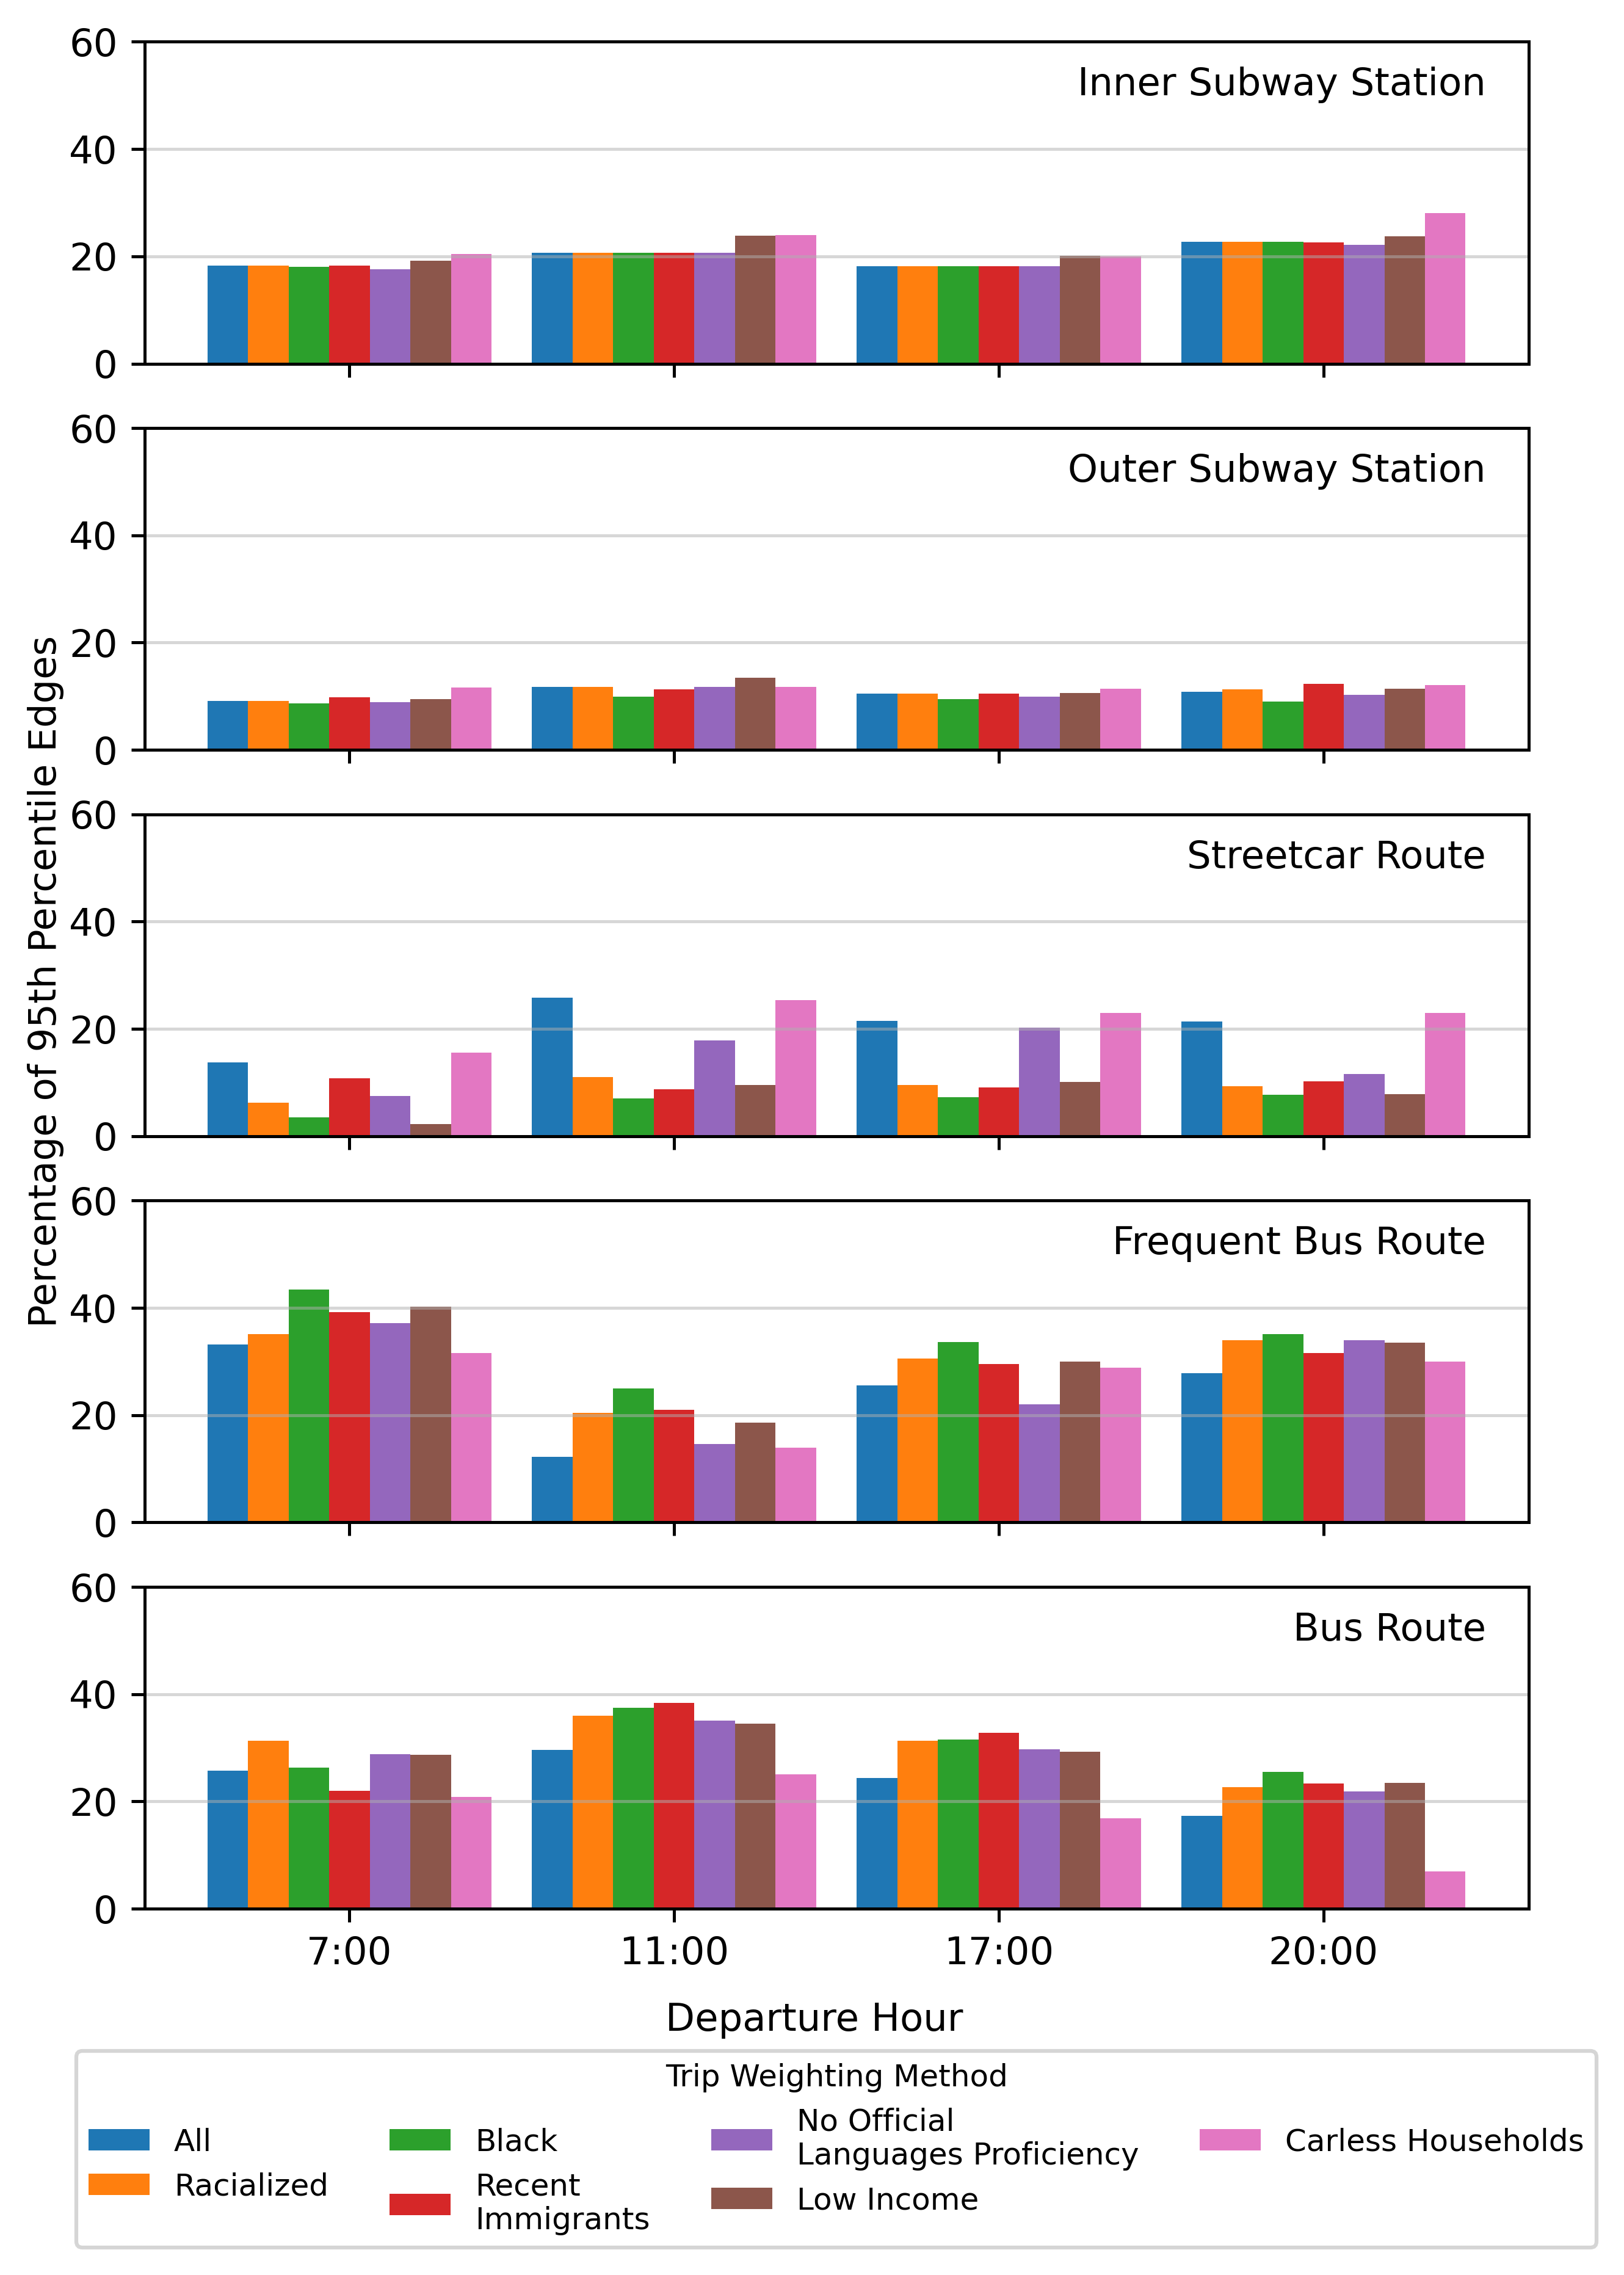

In [41]:
fig, ax = plt.subplots(5,1, sharex = True)

fig.set_size_inches(6.5,9)

x = np.arange(4) 

i = 0
for mode in ['Inner Subway Station', 'Outer Subway Station', 'Streetcar Route', 'Frequent Bus Route', 'Bus Route']:

    ax[i].grid(axis = 'y', alpha = 0.5)

    data = bc_class[bc_class['edge_type']== mode]

    ax[i].bar(x-3/8,data[data['group']=='raw']['prop'], width = 1/8, label = 'All', color = cmap(0))
    ax[i].bar(x-2/8,data[data['group']=='rac']['prop'], width = 1/8, label = 'Racialized', color = cmap(1))
    ax[i].bar(x-1/8,data[data['group']=='bl']['prop'], width = 1/8, label = 'Black', color = cmap(2))
    ax[i].bar(x,data[data['group']=='imm']['prop'], width = 1/8, label = 'Recent\nImmigrants', color = cmap(3))
    ax[i].bar(x+1/8,data[data['group']=='lep']['prop'], width = 1/8, label = 'No Official\nLanguages Proficiency', color = cmap(4))
    ax[i].bar(x+2/8,data[data['group']=='lico']['prop'], width = 1/8, label = 'Low Income', color = cmap(5))
    ax[i].bar(x+3/8,data[data['group']=='c0']['prop'], width = 1/8, label = 'Carless Households', color = cmap(6))

    ax[i].set_ylim([0,60])

    ax[i].set_xticks(range(4))
    ax[i].set_xticklabels(['7:00', '11:00', '17:00', '20:00'])
    
    ax[i].text(3.5,50,mode, ha = 'right')

    i = i + 1
    
fig.text(0.5, 0.08, 'Departure Hour', ha='center', va='center')
fig.text(0.08, 0.5, 'Percentage of 95th Percentile Edges', ha='right', va='center', rotation = 90)

plt.legend(title = 'Trip Weighting Method', title_fontsize = 8, fontsize = 8, ncol = 4,
          loc='lower center', bbox_to_anchor=(0.5, -1.1))

plt.savefig('bc_mode.png', dpi = 300, bbox_inches = "tight")

In [42]:
data

,type,edge_type,count,total,group,period,prop,period_order
0,bl_am,Bus Route,127,482,bl,AM,26.349,2
20,lico_am,Bus Route,127,442,lico,AM,28.733,2
25,rac_am,Bus Route,151,482,rac,AM,31.328,2
30,raw_am,Bus Route,124,482,raw,AM,25.726,2
5,c0_am,Bus Route,90,431,c0,AM,20.882,2
10,imm_am,Bus Route,106,482,imm,AM,21.992,2
15,lep_am,Bus Route,139,482,lep,AM,28.838,2
80,imm_md,Bus Route,163,425,imm,MD,38.353,3
70,bl_md,Bus Route,159,425,bl,MD,37.412,3
75,c0_md,Bus Route,92,367,c0,MD,25.068,3


In [43]:
data[data['group']=='raw']

,type,edge_type,count,total,group,period,prop,period_order
30,raw_am,Bus Route,124,482,raw,AM,25.726,2
100,raw_md,Bus Route,126,426,raw,MD,29.577,3
135,raw_pm,Bus Route,118,485,raw,PM,24.330,4
65,raw_ev,Bus Route,67,388,raw,EV,17.268,5
